# Graph Signal Processing using TV regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, plotting
from sklearn.metrics import mean_squared_error
import pyunlocbox
from random import random

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'
adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
ratings = pd.read_csv(GENERATED_PATH+'ratings_matrix.csv', index_col=0)

## Total variation regularization

The approach we take to solve the movie recommandation system is that each set of ratings coming from a user is a signal lying on the graph of movies previously constructed.

The problem is that a lot of ratings are missing. The known ratings are between 1 and 5 and the unknown ratings are equal to 0.

We try to reconstruct the signal of the ratings for all movies using a TV regularization method. Indeed because the signal of ratings is a picewise constant function it is the most appropriate approach to recover the signal.

The TV regularization method try to recover the signal $x$ by solving the optimization problem :

$$
\tilde{x}=\underset{x \in \mathbb{R}^{N}}{\arg \min }\|A x-y\|_{2}^{2}+R_{\mathrm{tv}}(x ; G)
$$

where $R_{\mathrm{tv}}(x ; G)=\alpha\|S x\|_{1}=\alpha \sum_{w_{i j} \in E} \sqrt{w_{i j}}|x(i)-x(j)|$

## Using Movie Ratings Graph
### Small network

To begin we just use the first signal (the first user)

In [2]:
ratings[ratings > 0].count(axis=1).sort_values(ascending=False)

UserId
13     304
276    293
416    270
655    270
303    262
      ... 
300     10
242      9
565      7
558      7
855      4
Length: 943, dtype: int64

In [3]:
signal = ratings.loc[13].reset_index(drop = True)
indexes = np.array(signal[signal >0].index.to_list())

We use the first 161 movies which are all rated by this user. So we can see the evolution of the MSE with the percentage of missing ratings

In [4]:
adj = adjacency[indexes][:, indexes]
signal = signal[indexes]
G = graphs.Graph(adj)
G.set_coordinates()

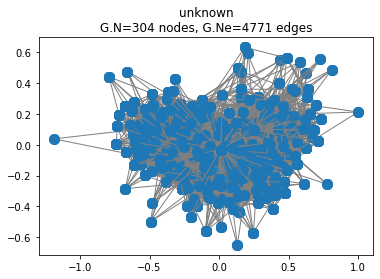

In [5]:
# Load graph
G = graphs.Graph(adj)
G.set_coordinates()
G.plot()

In [6]:
# This function solve the optimization problem of the TV regularization
def tv_reg(G, noisy, mask, gamma = 3):
    # Set the functions in the problem
    d = pyunlocbox.functions.dummy()
    r = pyunlocbox.functions.norm_l1()
    f = pyunlocbox.functions.norm_l2(w=mask, y=noisy, lambda_=gamma)

    # Define the solver
    G.compute_differential_operator()
    L = G.D.toarray()
    step = 0.999 / (1 + np.linalg.norm(L))
    solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

    # Solve the problem
    x0 = noisy.copy()
    prob1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000, verbosity='NONE')

    return prob1['sol']

In [71]:
# Create the mask
rs = np.random.RandomState()
mask = rs.rand(G.N)
mask = (mask > 0.7).astype(float)
noisy = signal * mask
inverse_mask = mask * -1 + 1

test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

We perform a validation test for the parameter gamma

Best gamma :  13
RMSE :  0.8981919646201719


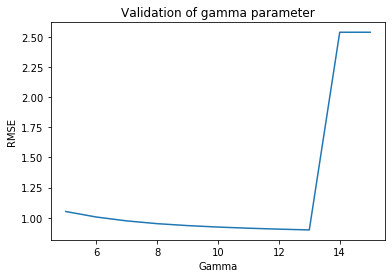

In [72]:
# Reconstruct the signal
errors = []
best_error = np.inf
best_gamma = 0
for gamma in range(5,16):
    reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=gamma), 1, 5)

    test_reconstructed = reconstructed * inverse_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
    if error < best_error:
        best_error = error
        best_gamma = gamma
    errors.append(error)

# we compute the mean squared error only between the ratings we didn't know
print("Best gamma : ", best_gamma)
print("RMSE : ", best_error)

plt.figure()
plt.plot(range(5,16), errors)
plt.title("Validation of gamma parameter")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


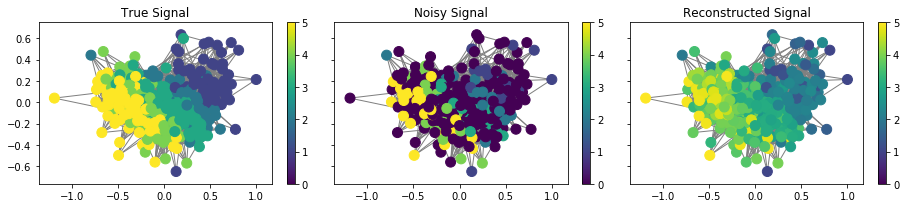

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(13, 3))
limits = [0, 5]
_ = G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
_ = G.plot_signal(noisy, ax=ax2, limits=limits, plot_name='Noisy Signal')
_ = G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal')
_ = fig.tight_layout()

We will compare this results whith a dummy program which always return 3

In [75]:
test_true = signal * inverse_mask
test_true = test_true[test_true != 0]

test_reconstructed = np.ones(len(signal)) * inverse_mask * np.mean(signal)
test_reconstructed = test_reconstructed[test_reconstructed != 0]

# we compute the mean squared error only between the ratings we didn't know
dummy_error = np.sqrt(mean_squared_error(test_true, test_reconstructed))
print("Dummy RMSE : ", dummy_error)

Dummy RMSE :  1.4038517779154733


We perform better than the dummy program !

Now let's look at how the RMSE evolve with the percentage of missing value.

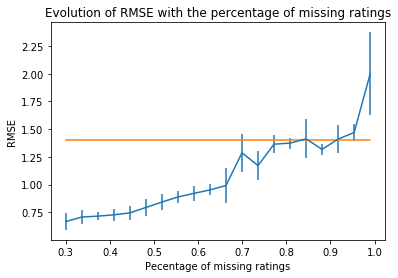

In [76]:
missing = np.linspace(0.3, 0.99, 20)
errors = np.ndarray(shape=(10, len(missing)))
for i in range(10):
    rs = np.random.RandomState()
    for j, missing_percentage in enumerate(missing):
        # Create the mask
        mask = rs.rand(G.N)
        mask = (mask > missing_percentage).astype(float)
        noisy = signal * mask
        # Compute errors
        inverse_mask = mask * -1 + 1

        test_true = signal * inverse_mask
        test_true = test_true[test_true != 0]

        reconstructed = np.clip(tv_reg(G, noisy, mask, gamma=13), 1, 5)
        test_reconstructed = reconstructed * inverse_mask
        test_reconstructed = test_reconstructed[test_reconstructed != 0]
        errors[i,j] = np.sqrt(mean_squared_error(test_true, test_reconstructed))

plt.figure()
plt.errorbar(missing, np.mean(errors, axis=0), yerr=np.std(errors, axis=0), label="Our algorithm")
plt.plot(missing, np.ones(len(missing))*dummy_error)
plt.title("Evolution of RMSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("RMSE")
plt.savefig(RESULT_PATH+'evolution_rmse_missing.eps')
plt.show()

We can see that 

## Entire network

### Test with one user

We will now try with the whole network (still for the first user). The principle is really the same but we have to carefully design the mask. Indeed the mask must be 0 for every unknown entry and 30% of known entry and 1 elsewhere.

In [100]:
signal = ratings.loc[1]

In [101]:
# Laod graph
G = graphs.Graph(adjacency)
G.set_coordinates()

In [102]:
def create_mask(signal, valid_percent, test_percent):
    mask = np.zeros(len(signal))
    validation_mask = np.zeros(len(signal))
    test_mask = np.zeros(len(signal))
    for i in range(len(signal)):
        if signal[i] != 0:
            x = random()
            if x < test_percent:
                test_mask[i] = 1
            elif x < test_percent + valid_percent:
                validation_mask[i] = 1
            else:
                mask[i] = 1
    return mask, validation_mask, test_mask

/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pyunlocbox/functions.py:494: RuntimeWarning: overflow encountered in double_scalars
  return self.lambda_ * np.sum((self.w * sol)**2)
/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pyunlocbox/solvers.py:286: RuntimeWarning: invalid value encountered in double_scalars
  relative = np.abs((current - last) / div)
/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pyunlocbox/functions.py:494: RuntimeWarning: overflow encountered in square
  return self.lambda_ * np.sum((self.w * sol)**2)
/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pyunlocbox/functions.py:494: RuntimeWarning: overflow encountered in double_scalars
  re

Best gamma :  11
Validation RMSE :  1.1619521224420573
Test RMSE :  1.5321885770507597


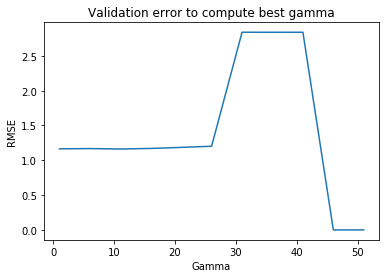

In [103]:
# create mask
mask, validation_mask, test_mask = create_mask(signal, 0.2, 0.2)
noisy_validation = signal * mask
validation_true = signal * validation_mask
validation_true = validation_true[validation_true != 0]

errors = []
best_error = np.inf
best_gamma = 0
interval = range(1, 52, 5)

for gamma in interval:
    reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)
    
    if(np.isnan(reconstructed).any()):
        errors.append(0)
        continue
    # Compute errors
    validation_reconstructed = reconstructed * validation_mask
    validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
    error = np.sqrt(mean_squared_error(validation_true, validation_reconstructed))
    
    if error < best_error:
        best_error = error
        best_gamma = gamma

    errors.append(error)

# retrain using train and validation data
mask += validation_mask
noisy_test = signal * mask
reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)

test_true = signal * test_mask
test_true = test_true[test_true != 0]

test_reconstructed = reconstructed * test_mask
test_reconstructed = test_reconstructed[test_reconstructed != 0]
print("Best gamma : ", best_gamma)
print("Validation RMSE : ", best_error)
print("Test RMSE : ", np.sqrt(mean_squared_error(test_true, test_reconstructed)))

plt.figure()
plt.plot(interval, errors)
plt.title("Validation error to compute best gamma")
plt.xlabel("Gamma")
plt.ylabel("RMSE")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(13, 3))
limits = [0, 5]
_ = G.plot_signal(signal, ax=ax1, limits=limits, plot_name='True Signal')
_ = G.plot_signal(noisy_test, ax=ax2, limits=limits, plot_name='Noisy Signal')
_ = G.plot_signal(reconstructed, ax=ax3, limits=limits, plot_name='Reconstructed Signal')
_ = fig.tight_layout()

### Test over all users
Now we will test the TV regularization over all users. Each of them reprensent a signal lying on the graph. We will use a test set of 30% of the rated movie for all users

In [18]:
test_errors = []
best_gammas = []
percentage_data = []
for idx, signal in ratings.iterrows():
    # create mask
    mask, validation_mask, test_mask = create_mask(signal, 0.2, 0.1)
    noisy_validation = signal * mask
    errors = []
    best_error = np.inf
    best_gamma = 0
    interval = np.linspace(0.1, 6, 50)
    for gamma in interval:
        reconstructed = np.clip(tv_reg(G, noisy_validation, mask, gamma=gamma), 1, 5)

        # Compute errors
        validation_true = signal * validation_mask
        validation_true = validation_true[validation_true != 0]

        validation_reconstructed = reconstructed * validation_mask
        validation_reconstructed = validation_reconstructed[validation_reconstructed != 0]
        error = mean_absolute_error(validation_true, validation_reconstructed)

        if error < best_error:
            best_error = error
            best_gamma = gamma
        errors.append(error)

    # retrain using train and validation data
    mask += validation_mask
    noisy_test = signal * mask
    reconstructed = np.clip(tv_reg(G, noisy_test, mask, gamma=best_gamma), 1, 5)

    test_true = signal * test_mask
    test_true = test_true[test_true != 0]

    test_reconstructed = reconstructed * test_mask
    test_reconstructed = test_reconstructed[test_reconstructed != 0]
    
    best_gammas.append(best_gamma)
    test_errors.append(mean_absolute_error(test_true, test_reconstructed))
    percentage_data.append(len(noisy_test[noisy_test != 0])/len(signal))

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Using Movie feature Graph

In this section @Lukas you can do the same analysis but using the movie feature graph